# Classification of P300 Event-Related Potentials and <br /> Data Preparation for 64-Channel BioSemi  Data

__Elliott Forney - 2020__

In [1]:
import pickle

import numpy as np
import scipy as sp
import scipy.signal as _

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8.5]

In [2]:
!ls ~/data/eeg/csu/subject-053/

notes
s13-d1-p300grid-test-perfunctory-3trials.png
s13-d1-p300grid-test-rocks.pkl
s13-d1-p300grid-test-rocks.png
s13-d1-p300grid-test-state.pkl
s13-d1-p300grid-test-state.png
s13-d1-p300grid-test-university.pkl
s13-d1-p300grid-test-university.png
s13-d1-p300grid-train-colorado2.pkl
s13-d1-p300grid-train-colorado2.txt
s13-d1-p300grid-train-colorado.pkl
s13-d1-p300grid-train-colorado.txt


In [3]:
subject = 53

In [4]:
with open(f'data/subject-{subject:03}/s13-d1-p300grid-train-colorado.pkl', mode='rb') as fh:
    raw_train_data = pickle.load(fh, encoding='bytes')

In [5]:
with open(f'data/subject-{subject:03}/s13-d1-p300grid-test-state.pkl', mode='rb') as fh:
    raw_valid_data = pickle.load(fh, encoding='bytes')

In [6]:
with open(f'data/subject-{subject:03}/s13-d1-p300grid-test-university.pkl', mode='rb') as fh:
    raw_test_data = pickle.load(fh, encoding='bytes')

In [7]:
raw_train_data.shape, raw_valid_data.shape, raw_test_data.shape

((256647, 73), (166477, 73), (200877, 73))

In [8]:
chan_names = (
    'Fp1', 'AF7', 'AF3', 'F1',  'F3',  'F5',  'F7',  'FT7',                                  
    'FC5', 'FC3', 'FC1', 'C1',  'C3',  'C5',  'T7',  'TP7',                                  
    'CP5', 'CP3', 'CP1', 'P1',  'P3',  'P5',  'P7',  'P9',                                   
    'PO7', 'PO3', 'O1',  'Iz',  'Oz',  'POz', 'Pz',  'CPz',                                  
    'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz',  'F2',  'F4',                                   
    'F6',  'F8',  'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz',                                   
    'C2',  'C4',  'C6',  'T8',  'TP8', 'CP6', 'CP4', 'CP2',                                  
    'P2',  'P4',  'P6',  'P8',  'P10', 'PO8', 'PO4', 'O2',                                   
    'EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'
)

In [9]:
def plot_trace(data, samp_rate, nsec=10, chan_names=chan_names, scale_factor=0.5):
    assert isinstance(data, np.ndarray)
    assert data.ndim == 2
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    nstep = nsec * samp_rate
    data = data[:nstep]
    
    nchan = data.shape[1]
    chan_names = chan_names[:nchan]
    
    scale = np.max(np.abs(data))                                                                                                                                                                   
    sep = -np.arange(data.shape[1]) * scale_factor * scale
    data = data + sep
        
    time = np.linspace(0, nsec, data.shape[0])
    
    ax.plot(time, data)
    ax.set_xlabel(r'Time ($s$)')
    ax.set_ylabel(r'Signal ($\mu V$) Across Channels')
    ax.set_yticklabels([c for i, c in enumerate(chan_names)])
    ax.set_yticks(sep)
    ax.autoscale(tight=True)

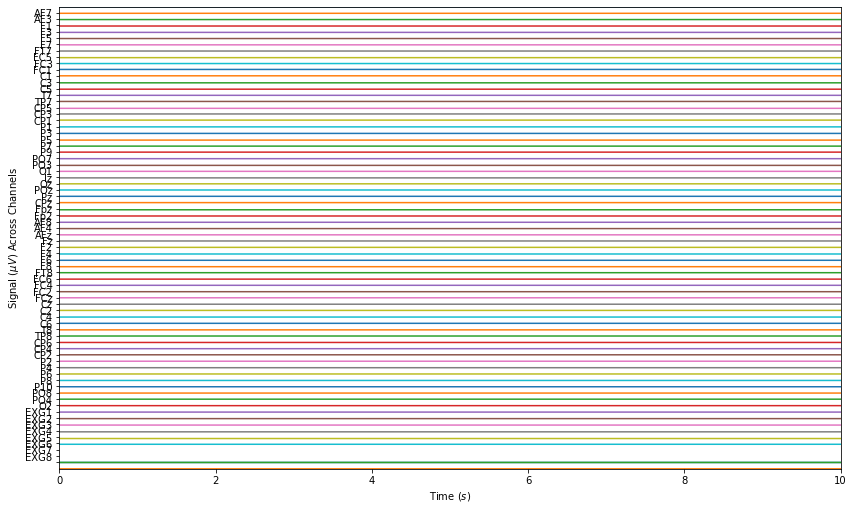

In [10]:
plot_trace(raw_train_data, 1024)

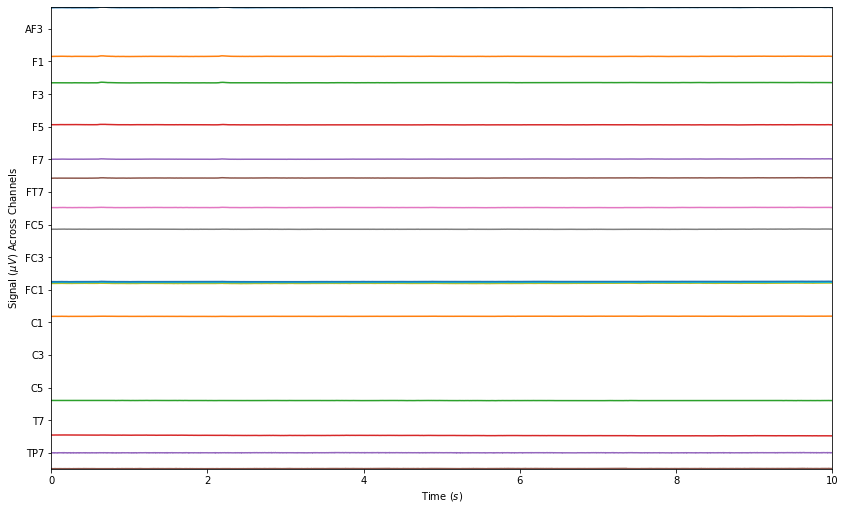

In [11]:
plot_trace(raw_train_data[:, :16], 1024)

In [12]:
train_data = raw_train_data.copy()

In [13]:
train_data -= train_data.mean(axis=0)

In [14]:
ref_chan_idxs = chan_names.index('EXG5'), chan_names.index('EXG6')
ref_chan_idxs

(68, 69)

In [15]:
reference = train_data[:, ref_chan_idxs].mean(axis=1)[:, None]
reference.shape

(256647, 1)

In [16]:
train_data -= reference

In [17]:
train_data -= train_data.mean(axis=0)

In [18]:
train_data = train_data[:, :64]

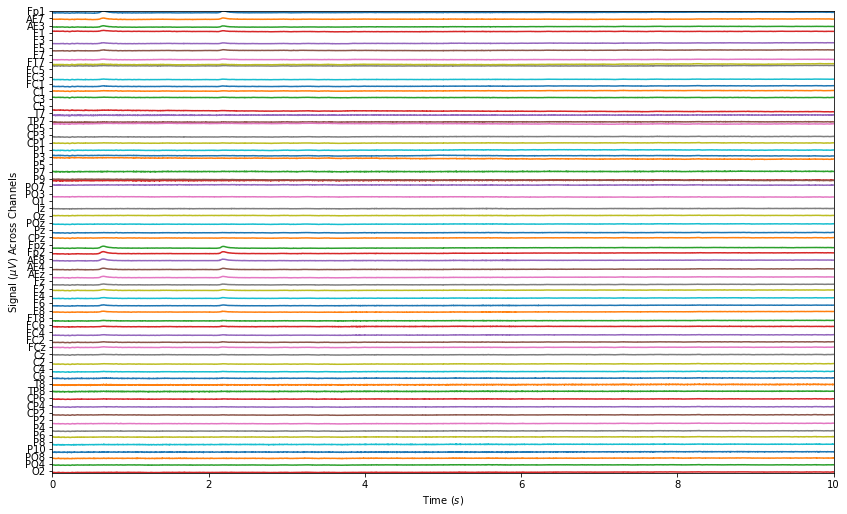

In [19]:
plot_trace(train_data, 1024)

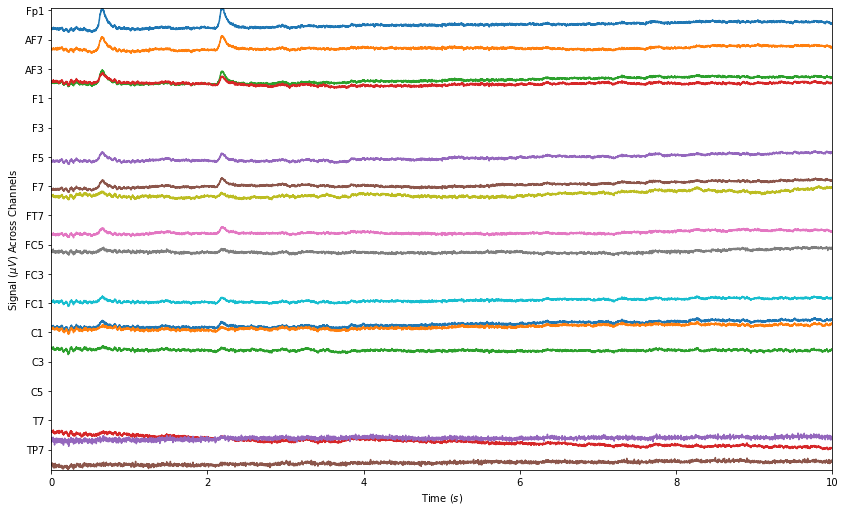

In [20]:
plot_trace(train_data[:, :16], 1024)

In [21]:
def make_bandpass(samp_rate, low_freq, high_freq, order=3):
    '''Bidirectional Butterworth linear IIR bandpass filter.
    '''
    nyquist = samp_rate * 0.5
    
    if low_freq < 0.0:
        raise ValueError(f'low filter corner {low_freq} must be greater than zero')
        
    if high_freq > nyquist:
        raise ValueError(f'high filter corner {high_freq} must be less than half the sampling rate')
    
    # frequency relative to nyquist rate
    low = low_freq / nyquist
    high = high_freq / nyquist
    
    # compute the filter coefficients
    numer_coef, denom_coef = sp.signal.iirfilter(
        order, (low, high), ftype='butter', btype='bandpass')
    
    def bandpass(data):
        # apply the filter in both directions
        return sp.signal.filtfilt(numer_coef, denom_coef, data, axis=0, padtype='even')
    
    return bandpass

In [22]:
bandpass = make_bandpass(1024, 0.5, 40.0)

In [23]:
train_data = bandpass(train_data)

In [24]:
1024 / 8

128.0

In [25]:
train_data = train_data[::8]

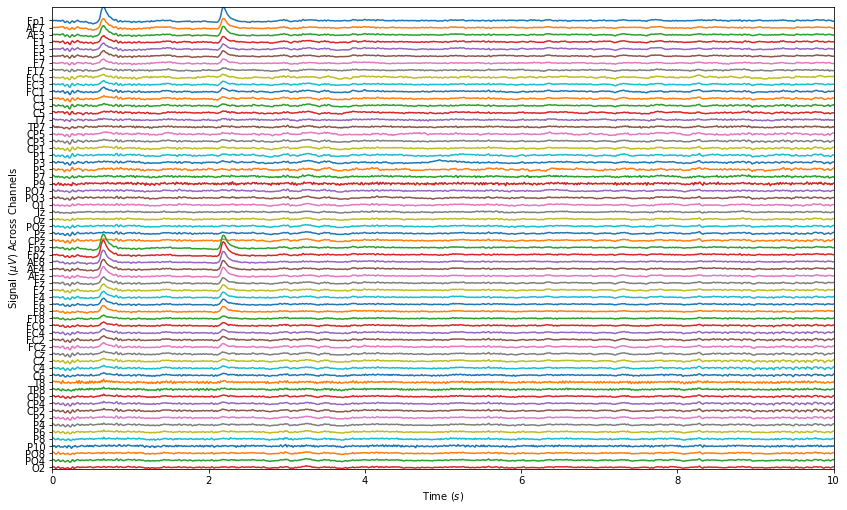

In [26]:
plot_trace(train_data, 128)

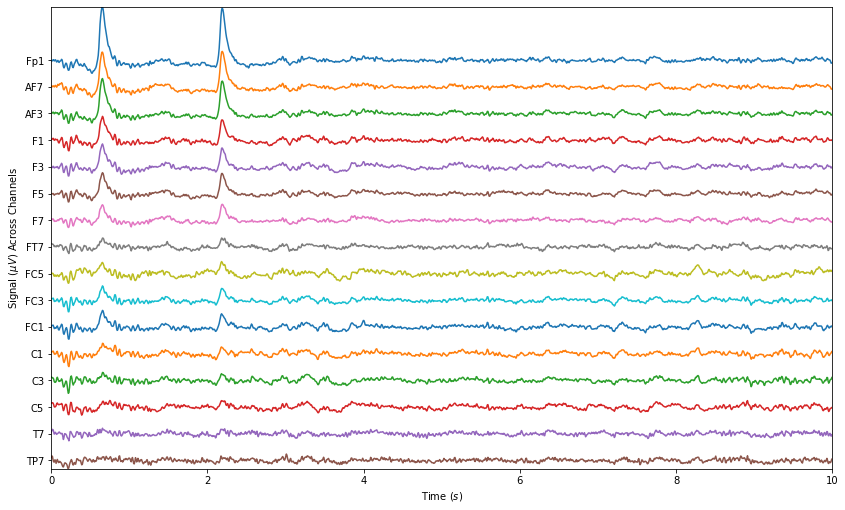

In [27]:
plot_trace(train_data[:, :16], 128)

## Welch's Power Spectral Density (PSD) to verify frequency content

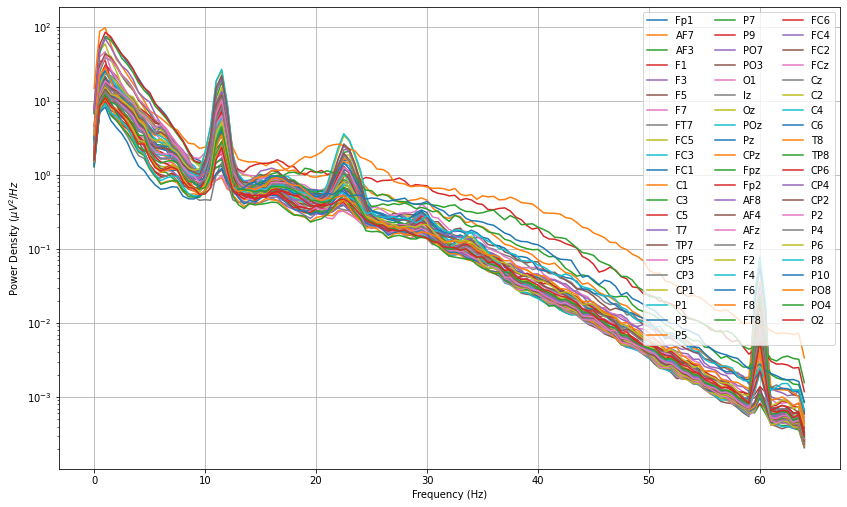

In [28]:
freqs, powers = sp.signal.welch(train_data.T, 128.0)

plt.plot(freqs, powers.T);
plt.xlabel('Frequency (Hz)');
plt.ylabel(r'Power Density ($\mu V^2/Hz$');
plt.yscale('log');
plt.grid();
plt.legend(chan_names, ncol=3);

## Don't forget the marker channel

In [29]:
train_markers = raw_train_data[::8, -1]
valid_markers = raw_valid_data[::8, -1]
test_markers = raw_test_data[::8, -1]

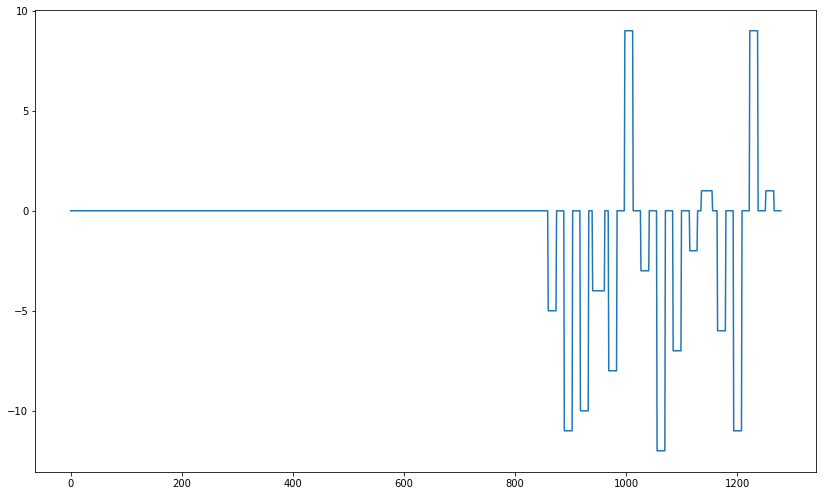

In [30]:
plt.plot(train_markers[:128*10]);

## Putting all the preprocessing together

In [31]:
def preprocess(raw_data, raw_samp_rate=1024, chan_names=chan_names,
               low_freq=0.5, high_freq=40.0, downsample_factor=8):
    # copy
    data = raw_data.copy()
    
    # demean
    data -= data.mean(axis=0)
    
    # reference
    ref_chan_idxs = chan_names.index('EXG5'), chan_names.index('EXG6')
    reference = data[:, ref_chan_idxs].mean(axis=1)[:, None]
    data -= reference
    
    # remove auxiliary channels
    data = data[:, :64]
    
    # bandpass
    # note: very inefficent to recreate the filter for each call
    bandpass = make_bandpass(
        samp_rate=raw_samp_rate,
        low_freq=low_freq, high_freq=high_freq)
    data = bandpass(data)[::downsample_factor]
    
    # extract marker channel
    markers = raw_data[::downsample_factor, -1]
    
    return data, markers

In [32]:
1024 / 8

128.0

In [33]:
train_data, train_markers = preprocess(raw_train_data)
valid_data, valid_markers = preprocess(raw_valid_data)
test_data, test_markers = preprocess(raw_test_data)

## Segmenting the data

In [34]:
diffs = np.diff(np.abs(train_markers))
diffs, diffs.shape

(array([0., 0., 0., 0., ..., 0., 0., 0., 0.]), (32080,))

In [35]:
starts = np.where(diffs > 0.0)[0] + 1
starts, starts.shape

(array([  860,   889,   918,   940, ..., 31805, 31827, 31856, 31885]), (960,))

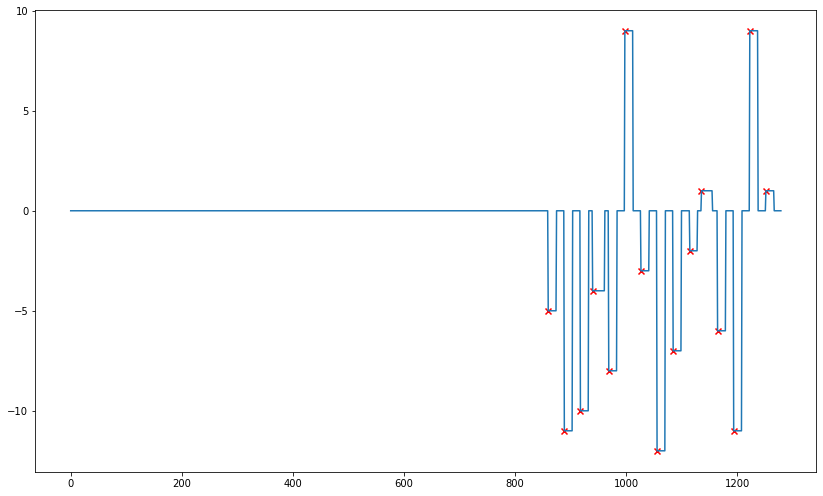

In [36]:
plt.plot(train_markers[:128*10]);
plt.scatter(starts[:15], train_markers[starts[:15]], marker='x', color='red');

In [37]:
segment_width_steps = int(0.8 * 128.0)
segment_width_steps

102

In [38]:
train_segments = np.stack([train_data[start:start+segment_width_steps] for start in starts])
train_segments.shape

(960, 102, 64)

In [39]:
labels = (train_markers[starts] > 0.0).astype(np.int)
labels, labels.shape

(array([0, 0, 0, 0, ..., 0, 0, 0, 1]), (960,))

In [40]:
np.sum(labels == 0)

800

In [41]:
np.sum(labels == 1)

160

## Putting segmentation steps together

In [42]:
def segment(data, markers, samp_rate=128.0, width=0.8):
    diffs = np.diff(np.abs(markers))
    starts = np.where(diffs > 0.0)[0] + 1
    
    width_steps = int(width * samp_rate)
    
    segments = np.stack([data[start:start+width_steps] for start in starts])
    labels = (markers[starts] > 0.0).astype(np.int)
    
    return np.ascontiguousarray(segments), labels

In [43]:
train_data, train_labels = segment(train_data, train_markers)
valid_data, valid_labels = segment(valid_data, valid_markers)
test_data, test_labels = segment(test_data, test_markers)

train_data.shape, valid_data.shape, test_data.shape

((960, 102, 64), (600, 102, 64), (600, 102, 64))

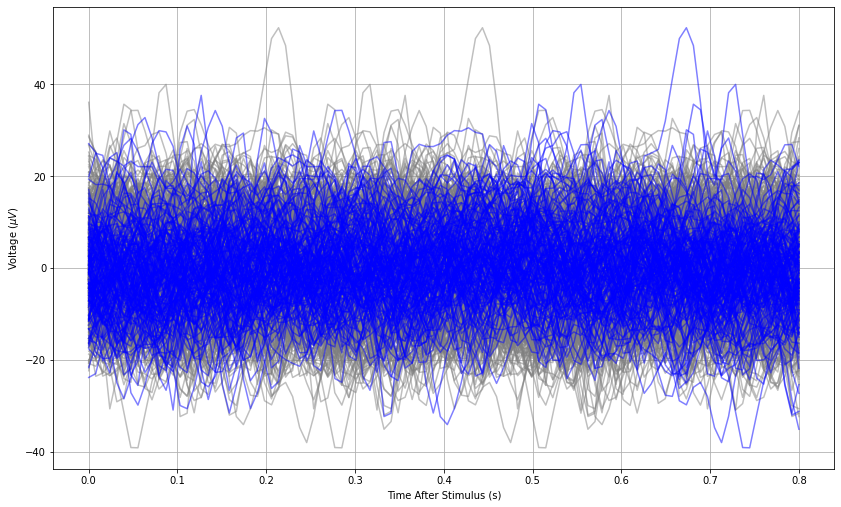

In [44]:
cz_index = chan_names.index('Cz')
time = np.linspace(0.0, 0.8, train_data.shape[1])

targets = train_data[train_labels == 0, :, cz_index]
nontargets = train_data[train_labels == 1, :, cz_index]

plt.plot(time, targets.T, color='grey', alpha=0.5);
plt.plot(time, nontargets.T, color='blue', alpha=0.5);
plt.xlabel('Time After Stimulus (s)')
plt.ylabel(r'Voltage ($\mu V$)')
plt.grid();

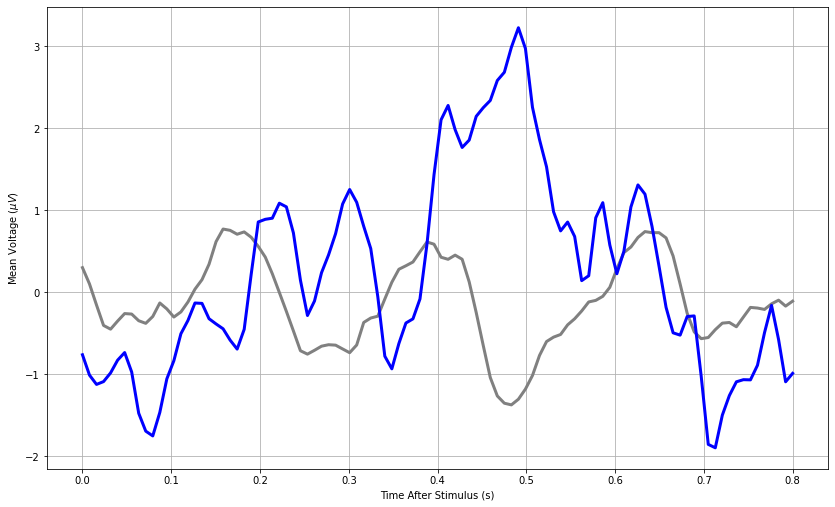

In [45]:
plt.plot(time, targets.mean(0), color='grey', linewidth=3, label='Target');
plt.plot(time, nontargets.mean(0), color='blue', linewidth=3, label='Nontarget');
plt.xlabel('Time After Stimulus (s)')
plt.ylabel(r'Mean Voltage ($\mu V$)')
plt.grid();

# Classification with Logistic Regression

In [46]:
import torch as th
import munch

In [47]:
class LogisticRegression(th.nn.Module):
    def __init__(self, nstep, nchan, ncls):
        super().__init__()        
        self.visible = th.nn.Linear(nstep * nchan, ncls)
        
    def forward(self, data):
        data = th.as_tensor(data, dtype=th.float32)
        assert data.ndimension() == 3
        
        return self.visible(data.reshape(data.shape[0], -1))
    
    def label(self, data):
        with th.no_grad():
            return th.argmax(self(data), axis=1)
    
    def probs(self, data):
        with th.no_grad():
            return th.nn.functional.softmax(self(data), dim=1)
        
    def fit(self, train_data, train_labels, valid_data, valid_labels, maxiter=500):
        
        train_data = th.as_tensor(train_data, dtype=th.float32)
        train_labels = th.as_tensor(train_labels, dtype=th.int64)
        valid_data = th.as_tensor(valid_data, dtype=th.float32)
        valid_labels = th.as_tensor(valid_labels, dtype=th.int64)
        
        result = munch.Munch({
            'train_losses': [],
            'valid_losses': [],
        })
        
        self.train()
        
        loss_func = th.nn.CrossEntropyLoss(reduction='mean')
        
        optimizer = th.optim.Rprop(self.parameters())

        for it in range(maxiter):
            optimizer.zero_grad()
            
            logits = self(train_data)
            loss = loss_func(logits, train_labels)
            result.train_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
            with th.no_grad():
                logits = self(valid_data)
                loss = loss_func(logits, valid_labels)
                result.valid_losses.append(loss.item())
                
        self.eval()
                
        return result

In [48]:
logreg = LogisticRegression(train_data.shape[1], train_data.shape[2], 2)

In [49]:
result = logreg.fit(train_data, train_labels, valid_data, valid_labels, maxiter=250)

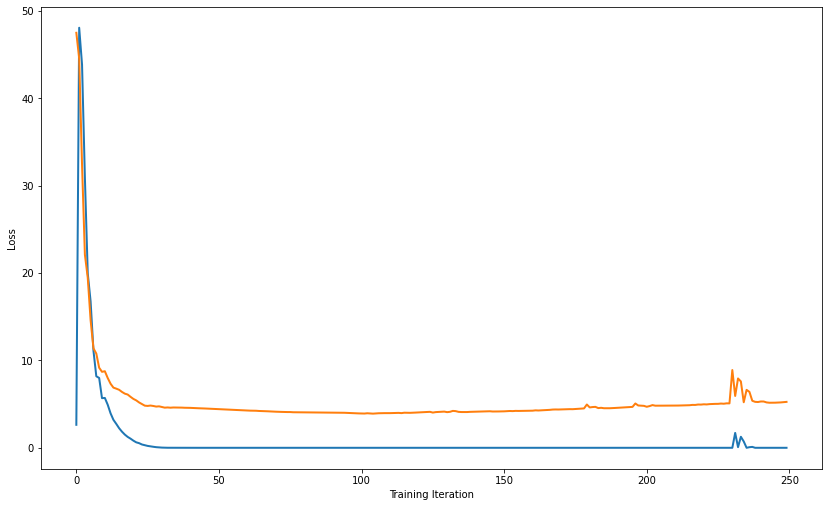

In [50]:
plt.plot(result.train_losses, linewidth=2, label='Train');
plt.plot(result.valid_losses, linewidth=2, label='Valid');
plt.xlabel('Training Iteration');
plt.ylabel('Loss');

In [51]:
train_preds = logreg.label(train_data).numpy()
valid_preds = logreg.label(valid_data).numpy()
test_preds = logreg.label(test_data).numpy()

In [52]:
from sklearn import metrics

In [53]:
print('train CA:', metrics.accuracy_score(train_labels, train_preds))
print('test CA:', metrics.accuracy_score(test_labels, test_preds))

train CA: 1.0
test CA: 0.825


In [54]:
print('train BCA:', metrics.balanced_accuracy_score(train_labels, train_preds))
print('test BCA:', metrics.balanced_accuracy_score(test_labels, test_preds))

train BCA: 1.0
test BCA: 0.687


In [55]:
train_probs = logreg.probs(train_data).numpy()
valid_probs = logreg.probs(valid_data).numpy()
test_probs = logreg.probs(test_data).numpy()

In [56]:
print('train AUC:', metrics.roc_auc_score(train_labels, train_probs[:, 1]))
print('test AUC:', metrics.roc_auc_score(test_labels, test_probs[:, 1]))

train AUC: 1.0
test AUC: 0.8037400000000001
